# Problem 1 - Predicting Descision to Lend

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import sqlite3

In [2]:
# connecting database
conn=sqlite3.connect("kinara_assessment_20190807.db")

In [3]:
# creating cursor object ointing to db
cur=conn.cursor()

In [4]:
# getting total count of files
cur.execute("select count(*) from loan_information")
tot_cnt_ln_inf=cur.fetchall()
cur.execute("select count(*) from enterprise_information")
tot_cnt_ent_Inf=cur.fetchall()
cur.execute("select count(*) from scores_information")
tot_cnt_score_inf=cur.fetchall()
cur.execute("select count(*) from disbursement_information")
tot_dis_inf=cur.fetchall()
print(tot_cnt_ln_inf)
print(tot_cnt_ent_Inf)
print(tot_cnt_score_inf)
print(tot_cnt_score_inf)

[(2476,)]
[(2476,)]
[(2476,)]
[(2476,)]


In [5]:
cur.execute("drop table disbursement_information_nonull")
# creating disbursement files with non null values before join

cur.execute("CREATE TABLE disbursement_information_nonull AS SELECT * FROM disbursement_information where account_number IS NOT NULL")

In [6]:
cur.execute("drop table loan_details")
# creating final merged table
cur.execute("create table loan_details as \
select a.loan_id,\
a.account_number,\
customer_id,\
a.enterprise_id,\
screening_date,\
product_code,\
hub_id,\
business_type,\
business_activity,\
business_sector,\
ManagAgeui_APP,\
BusinFormalityOfTheBusinessui,\
ManagCBscoreui_APP,\
total_disbursement_amount,\
disbursement_month \
from loan_information as a \
left join scores_information as b \
on a.loan_id = b.loan_id \
left join enterprise_information as c \
on a.loan_id= c.loan_id \
left join disbursement_information_nonull as d on a.account_number = d.account_number")
print(cur.fetchall())

[]


In [7]:
# matching the count of final merged table
cur.execute("select count(*) from loan_details")
print(cur.fetchall())


[(2476,)]


In [8]:
# creating dataframe from merged table
data=pd.read_sql_query("select * from loan_details",conn)
data.head()

,loan_id,account_number,customer_id,enterprise_id,screening_date,product_code,hub_id,business_type,business_activity,business_sector,ManagAgeui_APP,BusinFormalityOfTheBusinessui,ManagCBscoreui_APP,total_disbursement_amount,disbursement_month
0,29321,None,71846,24500.0,2018-04-19,None,53,None,Job Work,Machine Components,27.0,None,776.0,NaN,None
1,13613,TLWCU0003070,31083,10723.0,2017-08-10,TLWCU,39,Trading,Retail,Electronics,30.0,Invoice & Banked,616.0,400000.0,Aug-2017
2,13921,None,31928,11002.0,2017-08-17,None,56,None,Retail,Agriculture,55.0,None,793.0,NaN,None
3,16520,None,38660,13220.0,2017-10-21,None,58,None,Retail,Food & Beverage,26.0,None,781.0,NaN,None
4,49742,TLWCS0012623,119694,40426.0,2018-12-24,TLWCS,27,Manufacturing,Job Work & Sales,Textiles,30.0,Cash & Non Banked,689.0,500000.0,Jan-2019


In [9]:
data.head()

,loan_id,account_number,customer_id,enterprise_id,screening_date,product_code,hub_id,business_type,business_activity,business_sector,ManagAgeui_APP,BusinFormalityOfTheBusinessui,ManagCBscoreui_APP,total_disbursement_amount,disbursement_month
0,29321,None,71846,24500.0,2018-04-19,None,53,None,Job Work,Machine Components,27.0,None,776.0,NaN,None
1,13613,TLWCU0003070,31083,10723.0,2017-08-10,TLWCU,39,Trading,Retail,Electronics,30.0,Invoice & Banked,616.0,400000.0,Aug-2017
2,13921,None,31928,11002.0,2017-08-17,None,56,None,Retail,Agriculture,55.0,None,793.0,NaN,None
3,16520,None,38660,13220.0,2017-10-21,None,58,None,Retail,Food & Beverage,26.0,None,781.0,NaN,None
4,49742,TLWCS0012623,119694,40426.0,2018-12-24,TLWCS,27,Manufacturing,Job Work & Sales,Textiles,30.0,Cash & Non Banked,689.0,500000.0,Jan-2019


In [10]:
#creating label variable using account_number and imputing 0 for total_disbursement_amount  wherver there is null
data['target'] = np.where(data['account_number'].isnull(), 0, 1)
data['total_disbursement_amount'] = np.where(data['total_disbursement_amount'].isnull(), 0, data['total_disbursement_amount'])

In [11]:
#creating cibil categories using cibil scores
data['cibil_category'] = np.where(data['ManagCBscoreui_APP']==-1, 'No info', 
        (np.where(data['ManagCBscoreui_APP']==0,'LT_6_months',(np.where(data['ManagCBscoreui_APP'] <= 650, 'bad', 'good')))))

In [12]:
data.nunique()

loan_id                          2476
account_number                   1369
customer_id                      2443
enterprise_id                    2442
screening_date                    682
product_code                       16
hub_id                             90
business_type                       4
business_activity                   9
business_sector                    38
ManagAgeui_APP                     48
BusinFormalityOfTheBusinessui       4
ManagCBscoreui_APP                306
total_disbursement_amount          90
disbursement_month                 55
target                              2
cibil_category                      3
dtype: int64

In [13]:
#dropping id's and redundant variables from above step
data.drop(['account_number', 'ManagCBscoreui_APP', 'loan_id', 'customer_id', 
           'enterprise_id', 'disbursement_month', 'screening_date'], axis=1, inplace=True)

In [14]:
#missing value treatment: replacing the categorical variable with mode and numeric variable with mean
categ = list()
numeric = list()

for c in data.drop(['target'], axis=1).columns:

    if data[c].dtype == "object":
        print(c)
        categ.append(c)
        data[c].fillna(data[c].mode()[0], inplace = True)
    else:
        print(c)
        numeric.append(c)
        data[c].fillna(data[c].mean(), inplace = True)

product_code
hub_id
business_type
business_activity
business_sector
ManagAgeui_APP
BusinFormalityOfTheBusinessui
total_disbursement_amount
cibil_category


In [15]:
#creating collateral categories using product_type scores
data['collateral'] = np.where(data['product_code'].str[-1]=='U', 'Unsecured', 'Secured')
data.drop(['product_code'], axis=1, inplace=True)

In [16]:
numeric

['hub_id', 'ManagAgeui_APP', 'total_disbursement_amount']

<AxesSubplot:>

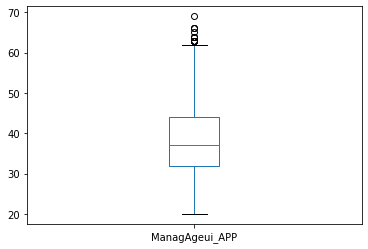

In [17]:
# drawing boxplots for age, though it has oulier according to scatter plot but they are legitimate age values so no outlier 
# treatment required
data.boxplot(column ='ManagAgeui_APP', grid = False)

<AxesSubplot:>

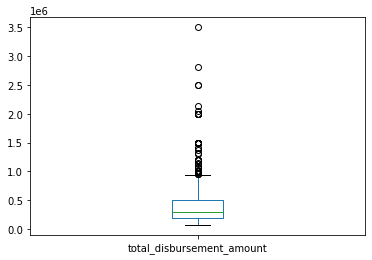

In [18]:
# drawing boxplots for total_disbursement_amount, though it has oulier according to box plot but they are legitimate
# total_disbursement_amount values so no outlier treatment required
data_disb = data[data['total_disbursement_amount']!=0]
data_disb.boxplot(column ='total_disbursement_amount', grid = False) 

In [19]:
categ

['product_code',
 'business_type',
 'business_activity',
 'business_sector',
 'BusinFormalityOfTheBusinessui',
 'cibil_category']

business_type,,Manufacturing,Services,Trading
target,,,,
0,0.0,792.0,3.0,312.0
1,1.0,802.0,5.0,561.0


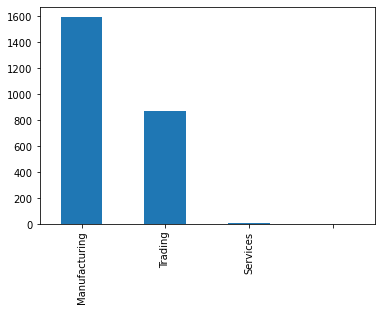

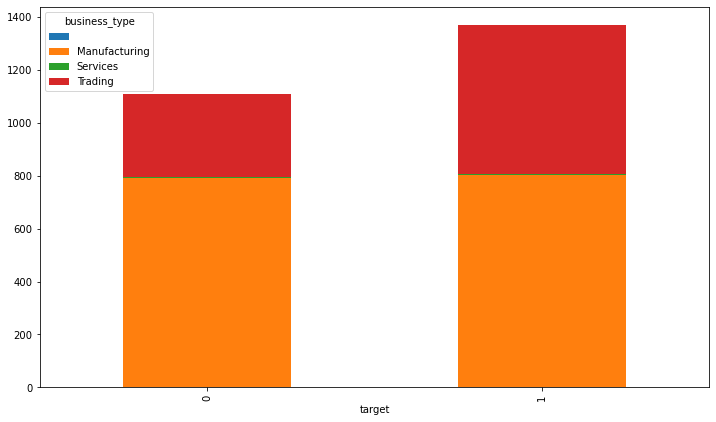

In [20]:
# distribution is skewed towards mnufacturing and trading, showing more laon applications from these types
data['business_type'].value_counts().plot(kind='bar')

df2 = data.groupby(['business_type', 'target'])['target'].count().unstack('business_type').fillna(0)
df2.plot(kind='bar', stacked=True, figsize=(12,7))
df2

business_activity,Job Work,Job Work & Sales,Job Work and sales,Retail,Retail (Business to Business),Retail (Business to Customer),Sales,Whole Sale,Whole sale
target,,,,,,,,,
0,135.0,230.0,0.0,380.0,1.0,3.0,189.0,169.0,0.0
1,187.0,252.0,4.0,365.0,3.0,2.0,360.0,195.0,1.0


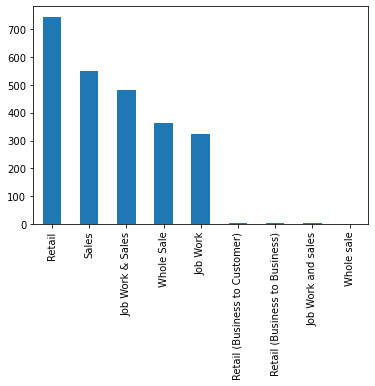

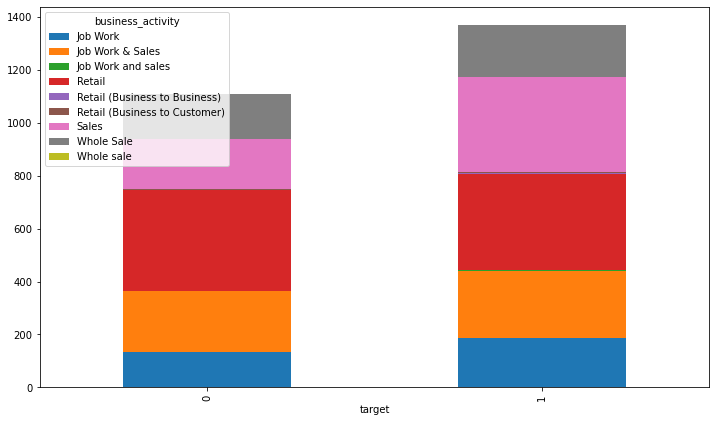

In [21]:
#  again distribution is skewed towards particular activities, showing more laon applications from these types
data['business_activity'].value_counts().plot(kind='bar')

df2 = data.groupby(['business_activity', 'target'])['target'].count().unstack('business_activity').fillna(0)
df2.plot(kind='bar', stacked=True, figsize=(12,7))
df2

BusinFormalityOfTheBusinessui,Cash & Banked,Cash & Non Banked,Invoice & Banked,Invoice & Non Banked
target,,,,
0,21,1015,36,35
1,57,1007,195,110


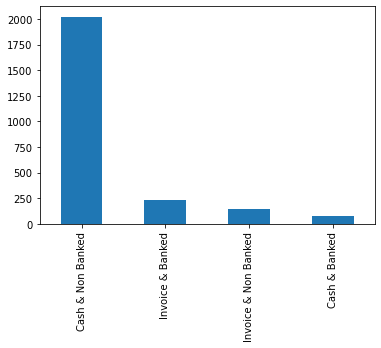

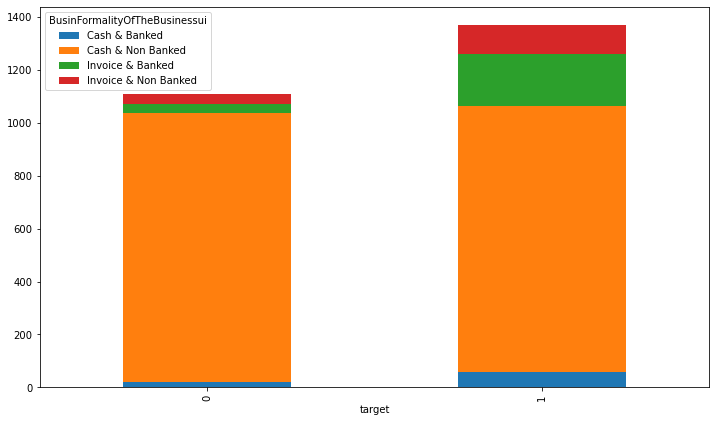

In [22]:
# distribution is skewed towards cash and non banked people, showing more laon applications from 
# these people dealing in cash transaction
data['BusinFormalityOfTheBusinessui'].value_counts().plot(kind='bar')

df2 = data.groupby(['BusinFormalityOfTheBusinessui', 'target'])['target'].count().unstack('BusinFormalityOfTheBusinessui').fillna(0)
df2.plot(kind='bar', stacked=True, figsize=(12,7))
df2

cibil_category,LT_6_months,bad,good
target,,,
0,169,307,631
1,274,128,967


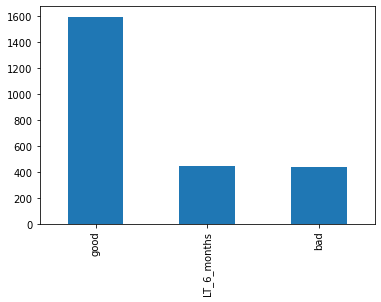

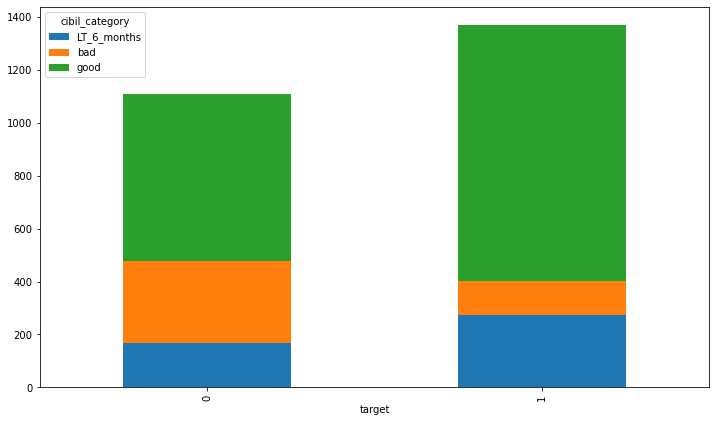

In [23]:
# most people have good cibil scores
data['cibil_category'].value_counts().plot(kind='bar')


df2 = data.groupby(['cibil_category', 'target'])['target'].count().unstack('cibil_category').fillna(0)
df2.plot(kind='bar', stacked=True, figsize=(12,7), )
df2

collateral,Secured,Unsecured
target,,
0,1084,23
1,797,572


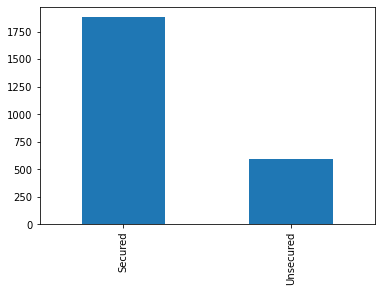

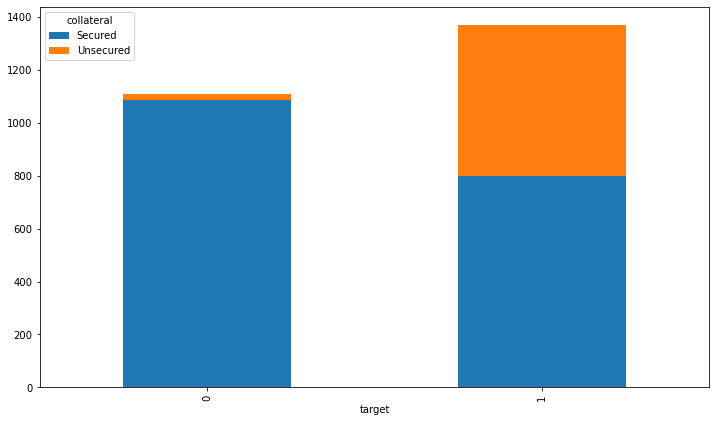

In [24]:
data['collateral'].value_counts().plot(kind='bar', )

df2 = data.groupby(['collateral', 'target'])['target'].count().unstack('collateral').fillna(0)
df2.plot(kind='bar', stacked=True, figsize=(12,7), )
df2

In [25]:
# since there are lot of categories most of them been skewed, we converte them to binary variables using one - hot encodeing 

categ.append('hub_id') #since hub id categorical var
categ.remove('product_code')#replaced with collateral
categ.append('collateral')#replaced with collateral

for c in categ:

    print(c)

    data= pd.get_dummies(data, columns=[c])

business_type
business_activity
business_sector
BusinFormalityOfTheBusinessui
cibil_category
hub_id
collateral


In [26]:
data.shape

(2476, 153)

In [27]:
# since there lot of variables post one-hot encoding and it is classification problem, xgboost can used as a powerful predictors
# capturing non linear relationships between independent and dependent variable

import xgboost as xgb

import pickle

from sklearn.model_selection import train_test_split

In [28]:
ind = data.drop(['target', 'total_disbursement_amount'], axis=1)
dep = data['target']

In [29]:
# splitting into train and test datasets for performnace evaluation
X_train, X_test, y_train, y_test = train_test_split(ind, dep, test_size=0.3, random_state=100)

In [30]:
train=xgb.DMatrix(X_train, label=y_train)

In [31]:
# following parametrs are bassed on small randomized grid seach
Xgb_iter1 = xgb.train({

'learning_rate': 0.05,

'booster' : 'gbtree',

'objective': 'binary:logistic',

'max_depth': 1,

'min_child_weight':15,

'seed' :11,

'verbose': True

}, dtrain=train, num_boost_round = 1000)

In [32]:
var_inp_dict = Xgb_iter1.get_score(importance_type='gain')

<AxesSubplot:>

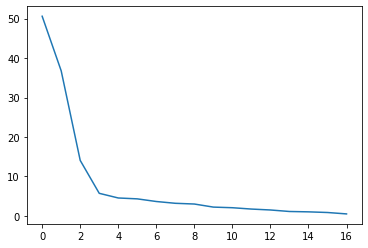

In [33]:
# variable importance visualization
var_imp_df = pd.DataFrame(list(var_inp_dict.items()), columns = ['Variable', 'Gain']).sort_values('Gain', ascending = False).reset_index()
var_imp_df.Gain.plot()

In [34]:
# selecting top variables based on gain
var_inp_dict

{'collateral_Secured': 50.610243946761905,
 'BusinFormalityOfTheBusinessui_Cash & Non Banked': 36.766885389600006,
 'cibil_category_bad': 14.060682668461546,
 'BusinFormalityOfTheBusinessui_Invoice & Banked': 5.715764215911767,
 'business_sector_Machine  Components': 4.3114860573846165,
 'business_activity_Retail': 2.221910196654639,
 'business_sector_Food & Beverage': 4.535018679250001,
 'business_activity_Job Work': 3.6407968400769235,
 'business_activity_Sales': 3.1876914649642853,
 'business_type_Manufacturing': 3.00180669046154,
 'business_activity_Whole Sale': 2.064435010579998,
 'ManagAgeui_APP': 1.491598301825397,
 'business_type_Trading': 1.7245502018471337,
 'business_sector_Textiles': 1.1097088454666666,
 'BusinFormalityOfTheBusinessui_Invoice & Non Banked': 1.0182727230555555,
 'cibil_category_LT_6_months': 0.8527603126428571,
 'business_sector_Auto Components': 0.49432414766666666}

In [35]:
var_list =[
'collateral_Secured',
 'BusinFormalityOfTheBusinessui_Cash & Non Banked',
 'cibil_category_bad',
 'BusinFormalityOfTheBusinessui_Invoice & Banked',
 'business_activity_Sales',
 'business_activity_Retail',
 'business_type_Manufacturing',
 'business_sector_Food & Beverage',
 'business_sector_Machine  Components',
 'business_activity_Whole Sale',
 'ManagAgeui_APP',
 'business_activity_Job Work',
 'business_sector_Textiles',
 'cibil_category_LT_6_months',
 'business_sector_Fabrication',
 'business_sector_Auto Components'
]

In [36]:
X_train2 = X_train[var_list]

In [37]:
X_test2 = X_test[var_list]

In [38]:
train=xgb.DMatrix(X_train2, label=y_train)

In [39]:
test=xgb.DMatrix(X_test2, label=y_test)

In [40]:
# grid search

default_param_grid = { 'max_depth': [1,2],
                      'learning_rate': [0.05, 0.1],
                      'num_boost_round': [500, 1000],
                      'min_child_weight': [15, 30]                     
                     }

col_names = ['max_depth', 'learning_rate', 'num_boost_round', 'min_child_weight', 'KS_dev', 'KS_itv']
grid_search  = pd.DataFrame(columns = col_names)

from sklearn.model_selection import ParameterGrid
param_df  = list(ParameterGrid(default_param_grid))
param_df = pd.DataFrame(param_df)
param_df

,learning_rate,max_depth,min_child_weight,num_boost_round
0,0.05,1,15,500
1,0.05,1,15,1000
2,0.05,1,30,500
3,0.05,1,30,1000
4,0.05,2,15,500
5,0.05,2,15,1000
6,0.05,2,30,500
7,0.05,2,30,1000
8,0.10,1,15,500
9,0.10,1,15,1000


In [41]:
# function to calculate ks
def KS_table_10(score, response):

 

    print('getting KS..')

 

    group = 10

 

    df = pd.DataFrame({'score': score, 'response' : response})

 

    df = df.sort_values(by = 'score', ascending = False)

 

    bin_size = len(score)/group

 

    rem = len(score) % group

 

    df['groups'] = list(np.repeat(range(1,rem+1),bin_size + 1)) + list(np.repeat(range(rem+1,11), bin_size))

 

    grouped = df.groupby('groups', as_index =False)

 

    agg = pd.DataFrame({'Total_Obs': grouped.count().response})

 

    agg['No.Res'] = grouped.sum().response

 

    agg['No.Non_Res'] = agg['Total_Obs'] - agg['No.Res']

 

    agg['min_pred'] = grouped.min().score

 

    agg['max_pred'] = grouped.max().score

 

    agg['pred_rr'] = grouped.mean().score

 

    agg['cum_no_res'] = agg['No.Res'].cumsum()

 

    agg['cum_no_non_res'] = agg['No.Non_Res'].cumsum()

 

    agg['percent_cum_res'] = agg['cum_no_res']/agg['cum_no_res'].max()

    agg['percent_cum_non_res'] = agg['cum_no_non_res']/agg['cum_no_non_res'].max()

 

    agg['KS'] = agg['percent_cum_res'] - agg['percent_cum_non_res']

    max_ks = agg['KS'].max()

    return(agg, max_ks)

In [42]:
# grid earch loop

for i in range(len(param_df)):
    Xgb_gs = xgb.train({

    'learning_rate': param_df['learning_rate'].iloc[i],
    
    'booster' : 'gbtree',

    'objective': 'binary:logistic',

    'max_depth': param_df['max_depth'].iloc[i],

    'gamma':0,

    'min_child_weight':param_df['min_child_weight'].iloc[i],

    'seed' :1,

    'verbose': True

    }, dtrain=train, num_boost_round = param_df['num_boost_round'].iloc[i])
    
    
    prob_train= Xgb_gs.predict(train)

    ks_tab_dev, ks_dev = KS_table_10(prob_train,y_train)
    
    
    prob_test= Xgb_gs.predict(test)

    ks_tab_test, ks_test = KS_table_10(prob_test,y_test)
    
    grid_search.loc[len(grid_search)] = [param_df['max_depth'].iloc[i], param_df['learning_rate'].iloc[i], 
                                         param_df['num_boost_round'].iloc[i], param_df['min_child_weight'].iloc[i],ks_dev, ks_test]

getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..
getting KS..


In [43]:
grid_search

,max_depth,learning_rate,num_boost_round,min_child_weight,KS_dev,KS_itv
0,1.0,0.05,500.0,15.0,0.504771,0.545764
1,1.0,0.05,1000.0,15.0,0.518903,0.545764
2,1.0,0.05,500.0,30.0,0.509582,0.547781
3,1.0,0.05,1000.0,30.0,0.516422,0.547781
4,2.0,0.05,500.0,15.0,0.535065,0.551233
5,2.0,0.05,1000.0,15.0,0.532885,0.547781
6,2.0,0.05,500.0,30.0,0.516422,0.553250
7,2.0,0.05,1000.0,30.0,0.532734,0.536842
8,1.0,0.10,500.0,15.0,0.507101,0.547781
9,1.0,0.10,1000.0,15.0,0.507101,0.542311


In [44]:
# following parametrs are bassed on small randomized grid seach (above gs is just for illustration purpose,
# here values were changed to achieve results)
Xgb_iter2 = xgb.train({

'learning_rate': 0.05,

'booster' : 'gbtree',

'objective': 'binary:logistic',

'max_depth': 1,

'gamma':0,

'min_child_weight':15,

'seed' :1,

'verbose': True

}, dtrain=train, num_boost_round = 1000)

In [45]:
# calculating ks on train
prob_train= Xgb_iter2.predict(train)

ks_dev = KS_table_10(prob_train,y_train)

getting KS..


In [46]:
ks_dev

(   Total_Obs  No.Res  No.Non_Res  min_pred  max_pred   pred_rr  cum_no_res  \
 0        174     169           5  0.956846  0.995000  0.970166         169   
 1        174     167           7  0.934736  0.956846  0.947163         336   
 2        174     145          29  0.746507  0.931297  0.839356         481   
 3        173     118          55  0.530646  0.743469  0.631640         599   
 4        173     100          73  0.490495  0.529871  0.502776         699   
 5        173      79          94  0.461738  0.490495  0.477950         778   
 6        173      80          93  0.399637  0.461738  0.431065         858   
 7        173      65         108  0.277865  0.399476  0.373569         923   
 8        173      26         147  0.166081  0.268260  0.219471         949   
 9        173       2         171  0.022065  0.166081  0.088035         951   
 
    cum_no_non_res  percent_cum_res  percent_cum_non_res        KS  
 0               5         0.177708             0.006394  0.

In [47]:
# calculating ks on test 
prob_test= Xgb_iter2.predict(test)

ks_test = KS_table_10(prob_test,y_test)

getting KS..


In [48]:
# ks on test data is decent and within~10% of dev data showig that model is not overfiiting and is stable. ALso we are able to 
# captue more than 50% rsponders in top 3 deciles

ks_test

(   Total_Obs  No.Res  No.Non_Res  min_pred  max_pred   pred_rr  cum_no_res  \
 0         75      73           2  0.959250  0.994481  0.974711          73   
 1         75      73           2  0.943619  0.959250  0.953390         146   
 2         75      70           5  0.824020  0.943619  0.893417         216   
 3         74      52          22  0.558469  0.824020  0.707751         268   
 4         74      41          33  0.497916  0.558469  0.523183         309   
 5         74      28          46  0.475556  0.497344  0.483647         337   
 6         74      38          36  0.403927  0.475556  0.438658         375   
 7         74      31          43  0.303199  0.400855  0.375650         406   
 8         74      11          63  0.144351  0.303199  0.224462         417   
 9         74       1          73  0.018069  0.143577  0.079530         418   
 
    cum_no_non_res  percent_cum_res  percent_cum_non_res        KS  
 0               2         0.174641             0.006154  0.

In [49]:
# Auc values are also >>50% showing significant lift from random
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds =roc_curve(y_train, prob_train)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.851695


In [50]:
# Auc values are also >>50% showing significant lift from random and within ~5 % from train showing model is not
# overfitting and is stable
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds =roc_curve(y_test, prob_test)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.862587


ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

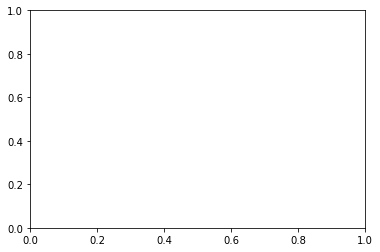

In [59]:
# visulaizing trees for xgb

from xgboost import plot_tree
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/gshik/Anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin'

plot_tree(Xgb_iter2, rankdir = 'LR', num_trees = 4)

# Problem 2 - Multiple Logistic Regression Implementation

In [78]:
# X_train=X_train.drop(['target','total_disbursement_amount','Unnamed: 0'],axis=1)
# mu=np.mean(X_train,axis=0)
# sigma=np.std(X_train,axis=0)
# X_train=(X_train-mu)/sigma


C:\Users\gshik\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [80]:
# defining the sigmoid function
def sigmoid(z):
    """
    Compute the sigmoid of each value of X_train.
    """
    
    z = np.array(z)
    
   
    g = np.zeros(z.shape)

  
    g=1/(1+np.exp(-z))
    

    return g

In [81]:
# Setup the data matrix appropriately, and add ones for the intercept term of logistic regression in training and test dataset
m, n = X_train2.shape
print(m,n)
# Adding intercept term to X_train 
X_train2 = np.concatenate([np.ones((m, 1)), X_train2], axis=1)
m, n = X_test2.shape
X_test2= np.concatenate([np.ones((m, 1)), X_test2], axis=1)
# print(X_train.shape)

1733 17


In [82]:
X_train2.shape

(1733, 18)

In [83]:
# defining logloss cost function

# Computing cost for logistic regression with multiple variables.
# Computing the cost, using theta as the parameter for logistic regression to fit the data points in X_tain and y_train.

      
def computeCostMulti(X, y, theta):
    
    m = y.shape[0] # number of training examples

    J=np.sum(((-y*np.log(sigmoid(np.dot(X,theta))))+(-(1-y)*np.log(1-sigmoid(np.dot(X,theta))))))/m
    #print(J)
    return J

theta=np.zeros(n+1) 
print(computeCostMulti(X_train2, y_train, theta))

0.6931471805599453


In [84]:
# function for gradient descent to learn and update theta.
# Updating theta by taking num_iters gradient steps with learning rate alpha.
        

def gradientDescentMulti(X, y, theta, alpha, num_iters):

    m = y.shape[0] # number of training examples
    
    # make a copy of theta, which will be updated by gradient descent
    theta = theta.copy()
    
    J_history = []
    
    for i in range(num_iters):
       
        theta=theta-(alpha*((np.dot(((sigmoid(np.dot(X,theta))-y)),X))/m))
        
#         J_history.append(computeCostMulti(X, y, theta))
    
    return theta, J_history

In [85]:
# Choose some alpha & ierations  - change this for trying different implementaion
alpha = 0.003
num_iters = 400

# init theta and run gradient descent
theta = np.zeros(n+1)
theta, J_history = gradientDescentMulti(X_train2, y_train, theta, alpha, num_iters)

print(theta)

[ 0.00551431  0.00551431 -0.10475728 -0.04772784 -0.05167783  0.03087584
  0.02529493 -0.02087495 -0.03220289 -0.00444025  0.01295735 -0.00236778
  0.00801764  0.00787101  0.00361745  0.01103646  0.0057169   0.0049077 ]


In [86]:
# predicting probablities for test datasets on weights or coeff learned from training data
def predict(theta, X):

    m = X.shape[0] # Number of training examples

    # You need to return the following variables correctly
    
    p = np.zeros(m)

    p = sigmoid(np.dot(X, theta))
    print(p)
    return p

In [87]:
predict(theta, X_train2)

[0.51794465 0.53190316 0.56911974 ... 0.57990304 0.57152686 0.55380255]


array([0.51794465, 0.53190316, 0.56911974, ..., 0.57990304, 0.57152686,
       0.55380255])

In [88]:
prob_test= predict(theta, X_test2)
ks_test = KS_table_10(prob_test,y_test)

[0.53101891 0.55848188 0.5469553  0.52270026 0.58247545 0.55572106
 0.54863373 0.51753781 0.52061604 0.57914262 0.55598734 0.50469084
 0.52643233 0.57095848 0.59662292 0.56527613 0.52015646 0.51228401
 0.55205003 0.55110334 0.52266387 0.54499106 0.53150101 0.55143734
 0.53591005 0.56635134 0.52961355 0.53951096 0.55553076 0.57901392
 0.52990641 0.56343475 0.53691026 0.54188681 0.52470017 0.54607003
 0.52593868 0.52102435 0.56883469 0.58499977 0.59362119 0.50610314
 0.56072914 0.52071438 0.54548201 0.54763834 0.51953946 0.50551967
 0.56083933 0.54225162 0.54997164 0.52689302 0.56540588 0.54743498
 0.56689173 0.53584776 0.56489759 0.53389092 0.53101891 0.54256222
 0.52643233 0.51590592 0.55739329 0.55750955 0.52502464 0.55994947
 0.53292102 0.54472586 0.54624309 0.55790358 0.53277222 0.54520791
 0.55798904 0.51953946 0.56825284 0.55180409 0.58335388 0.5391531
 0.50752239 0.55248297 0.54708614 0.58688538 0.51615295 0.54208301
 0.55686897 0.55663583 0.55284612 0.5548896  0.52505599 0.58630

In [89]:
ks_test

,Total_Obs,No.Res,No.Non_Res,min_pred,max_pred,pred_rr,cum_no_res,cum_no_non_res,percent_cum_res,percent_cum_non_res,KS
0,75,63,12,0.573781,0.611492,0.586785,63,12,0.150718,0.036923,0.113795
1,75,54,21,0.563435,0.573587,0.568179,117,33,0.279904,0.101538,0.178366
2,75,51,24,0.555987,0.563435,0.559422,168,57,0.401914,0.175385,0.226529
3,74,61,13,0.549431,0.555721,0.552693,229,70,0.547847,0.215385,0.332462
4,74,38,36,0.543568,0.549165,0.546247,267,106,0.638756,0.326154,0.312602
5,74,36,38,0.538133,0.543506,0.540807,303,144,0.724880,0.443077,0.281803
6,74,36,38,0.531019,0.538133,0.534303,339,182,0.811005,0.560000,0.251005
7,74,33,41,0.523693,0.531019,0.527649,372,223,0.889952,0.686154,0.203798
8,74,28,46,0.515030,0.523541,0.519564,400,269,0.956938,0.827692,0.129245
9,74,18,56,0.489769,0.515019,0.507957,418,325,1.000000,1.000000,0.000000


In [90]:
prob_test= predict(theta, X_train2)
ks_test = KS_table_10(prob_test,y_train)

[0.51794465 0.53190316 0.56911974 ... 0.57990304 0.57152686 0.55380255]
getting KS..


In [91]:
ks_test

,Total_Obs,No.Res,No.Non_Res,min_pred,max_pred,pred_rr,cum_no_res,cum_no_non_res,percent_cum_res,percent_cum_non_res,KS
0,174,151,23,0.573458,0.625776,0.585816,151,23,0.158780,0.029412,0.129368
1,174,133,41,0.562951,0.573450,0.567908,284,64,0.298633,0.081841,0.216792
2,174,115,59,0.554583,0.562926,0.558481,399,123,0.419558,0.157289,0.262269
3,173,112,61,0.548552,0.554518,0.551479,511,184,0.537329,0.235294,0.302035
4,173,92,81,0.541899,0.548489,0.545207,603,265,0.634069,0.338875,0.295195
5,173,93,80,0.535565,0.541870,0.538708,696,345,0.731861,0.441176,0.290685
6,173,83,90,0.529923,0.535531,0.532669,779,435,0.819138,0.556266,0.262872
7,173,83,90,0.523508,0.529906,0.526614,862,525,0.906414,0.671355,0.235059
8,173,53,120,0.515148,0.523468,0.519810,915,645,0.962145,0.824808,0.137337
9,173,36,137,0.488559,0.515014,0.508101,951,782,1.000000,1.000000,0.000000
